## Assignment 2
1. you have to create one **supervisor node**
2. router function
3. 3.1 llm call (**llm node**)
    
    3.2 RAG (**rag node**)
    
    3.3 web scrapping (internet) (**web scrapper node**)
    
4. created one more one for **validation** of generated output → explore the validation part
5. if validation going to be **fail** in that again go to **supervisor** and then supervisor will again decide what needs to be call **next**
6. once the **validation will pass** then only generated the final output

### Configure the model and embeddings

In [2]:
import os
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_huggingface import HuggingFaceEmbeddings

load_dotenv()
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")
os.environ["HUGGING_FACE_API"] = os.getenv("HUGGING_FACE_API")

llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

embeddings = HuggingFaceEmbeddings(model_name="BAAI/bge-small-en")
len(embeddings.embed_query("hi"))


c:\Users\aayushisharma\OneDrive - Nagarro\Agentic AI training\course hands on\Assignments\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


384

In [12]:
import operator
from typing import List
from pydantic import BaseModel , Field
from langchain.prompts import PromptTemplate
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph,END, START
from langchain.output_parsers import PydanticOutputParser
from langchain.document_loaders import PyPDFLoader, PyMuPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain_community.tools import DuckDuckGoSearchRun

### Creating our own Pydantic parser

In [4]:
class TopicSelectionParser(BaseModel):
    Topic:str=Field(description="selected topic")
    Reasoning:str=Field(description='Reasoning behind topic selection')

parser = PydanticOutputParser(pydantic_object=TopicSelectionParser)
parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"Topic": {"description": "selected topic", "title": "Topic", "type": "string"}, "Reasoning": {"description": "Reasoning behind topic selection", "title": "Reasoning", "type": "string"}}, "required": ["Topic", "Reasoning"]}\n```'

In [5]:
# Custom state
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

### creating supervisor and router function

In [25]:
#Node 1
def supervisor_function(state: AgentState):
    print("-> SUPERVISOR ->")
    question = state["messages"][-1]

    template="""
    Your task is to classify the given user query into one of the following related categories: [Constitution,LLM, Latest]. If question is about 
    Indian constitution then Constitution, if question is generic then LLM and if question is about some recent thing which you don't know then Latest.
    Only respond with the category name and nothing else.

    User query: {question}
    {format_instructions}
    """

    prompt = PromptTemplate(
        template=template,
        input_variables=["question"],
        partial_variables={"format_instructions": parser.get_format_instructions()}
    )

    chain = prompt | llm | parser
    result = chain.invoke({"question":question})
    return {"messages": [result.Topic]}

#Router function
def router(state:AgentState):
    print("-> ROUTER ->")
    last_message = state["messages"][-1]

    if "constitution" in last_message.lower():
        return "RAG CALL"
    elif "latest" in last_message.lower():
        return "WEB CALL"
    else:
        return "LLM CALL"
    

In [11]:
file_path = "20240716890312078.pdf"
loader = PyMuPDFLoader(file_path=file_path)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = text_splitter.split_documents(docs)

vector_store = FAISS.from_documents(chunks,embeddings)
retriever = vector_store.as_retriever()

### creating rag, llm and web search function

In [35]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

#Rag Node
def rag_function(state:AgentState):
    print("-> RAG Call ->")
    question = state["messages"][0]
    prompt=PromptTemplate(
        template="""You are an assistant for question-answering tasks. Use the following pieces 
        of retrieved context to answer the question. If you don't know the answer, 
        just say that you don't know. Use three sentences maximum and keep the
        answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:""",
        
        input_variables=['context', 'question']
    )

    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt 
        | llm
    )

    result = rag_chain.invoke(question)
    return {"messages": [result]}


# LLM Function
def llm_function(state:AgentState):
    print("-> LLM Call ->")
    question = state["messages"][0]
    
    # Normal LLM call
    complete_query = "Answer the follow question with you knowledge of the real world. Following is the user question: " + question
    response = llm.invoke(complete_query)
    return {"messages": [response.content]}


#Web Search Node
def search_web(state:AgentState):
    search  = DuckDuckGoSearchRun()
    result = search.invoke({"query": state["messages"][0]})
    return {"messages": [result]}


### Creating validation function

In [39]:
#Validator function
def validation(state:AgentState):
    
    question = state["messages"][0]
    answer=state["messages"][-1]
    
    print("answer",answer)
    
    template="""
    Your task is to check if the response is related to the user question. 
    Only respond with yes or no and nothing else.

    User query: {question}
    response: {answer}
    {format_instructions}
    """
    
    prompt= PromptTemplate(
        template=template,
        input_variable=["question","answer"],
        partial_variables={"format_instructions": parser.get_format_instructions()}
    )
    
    
    chain= prompt | llm | parser
    
    response = chain.invoke({"question":question,"answer":answer})
    
    print("Parsed response:", response)
    
    return {"messages": [response.Topic]}

#validation router
def router_1(state:AgentState):
    print("-> ROUTER_1 ->")
    
    last_message=state["messages"][-1]
    print("last_message:", last_message)
    
    if "yes" in last_message.lower():
        return "yes"
    else:
        return "no"

### Creating workflow

In [40]:
workflow = StateGraph(AgentState)
workflow.add_node("Supervisor",supervisor_function)
workflow.add_node("RAG",rag_function)
workflow.add_node("LLM",llm_function)
workflow.add_node("WEB SEARCH",search_web)
workflow.add_node("VALIDATION",validation)
workflow.set_entry_point("Supervisor")
workflow.add_conditional_edges(
    "Supervisor",
    router,
    {
        "RAG CALL": "RAG",
        "LLM CALL": "LLM",
        "WEB CALL": "WEB SEARCH"
    }
)

workflow.add_edge("RAG","VALIDATION")
workflow.add_edge("LLM","VALIDATION")
workflow.add_edge("WEB SEARCH","VALIDATION")

workflow.add_conditional_edges(
    "VALIDATION",
    router_1,
    {
        "yes":END,
        "no":"Supervisor"
    }
)
app=workflow.compile()

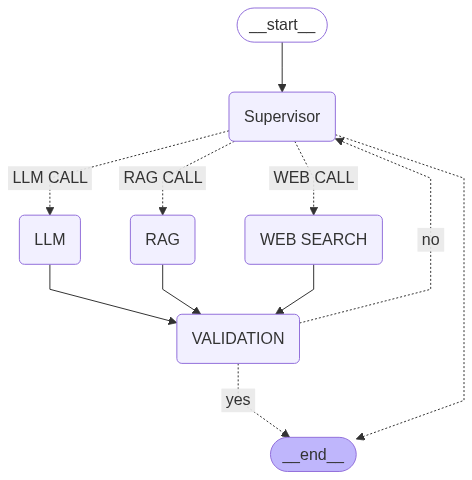

In [27]:
from IPython.display import Image, display
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [41]:
state={"messages":["How to make black tea?, list down in simple steps"]}
app.invoke(state)

-> SUPERVISOR ->
-> ROUTER ->
-> LLM Call ->
answer How to Make Black Tea:

1. **Boil Water:**  Heat fresh, cold water to a rolling boil.  The temperature is important; generally, water around 200-212°F (93-100°C) is best for black tea.

2. **Warm the Teapot (Optional but Recommended):**  Pour a small amount of boiling water into your teapot and swirl it around to warm it. This helps maintain the tea's temperature and prevents it from cooling down too quickly. Empty the water.

3. **Add Tea Leaves:** Add one teaspoon of loose leaf black tea or one tea bag per cup of water to the warmed teapot.  Adjust the amount to your taste; some prefer stronger tea.

4. **Pour Water Over Tea Leaves:** Slowly pour the boiling water over the tea leaves, ensuring all the leaves are submerged.

5. **Steep:** Let the tea steep for 3-5 minutes. Steeping time affects the strength and bitterness of the tea.  Experiment to find your preferred strength.  Longer steeping times generally result in a stronger, m

{'messages': ['How to make black tea?, list down in simple steps',
  'LLM',
  "How to Make Black Tea:\n\n1. **Boil Water:**  Heat fresh, cold water to a rolling boil.  The temperature is important; generally, water around 200-212°F (93-100°C) is best for black tea.\n\n2. **Warm the Teapot (Optional but Recommended):**  Pour a small amount of boiling water into your teapot and swirl it around to warm it. This helps maintain the tea's temperature and prevents it from cooling down too quickly. Empty the water.\n\n3. **Add Tea Leaves:** Add one teaspoon of loose leaf black tea or one tea bag per cup of water to the warmed teapot.  Adjust the amount to your taste; some prefer stronger tea.\n\n4. **Pour Water Over Tea Leaves:** Slowly pour the boiling water over the tea leaves, ensuring all the leaves are submerged.\n\n5. **Steep:** Let the tea steep for 3-5 minutes. Steeping time affects the strength and bitterness of the tea.  Experiment to find your preferred strength.  Longer steeping ti

In [42]:
state={"messages":["List all the fundamental duties?"]}
app.invoke(state)

-> SUPERVISOR ->
-> ROUTER ->
-> RAG Call ->
answer content="Fundamental duties of Indian citizens include abiding by the Constitution and respecting its ideals, cherishing national struggle ideals, and upholding India's sovereignty.  Other duties involve promoting harmony, preserving cultural heritage, protecting the environment, and developing scientific temper.  A complete list is detailed in Article 51A of the Constitution." additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-flash', 'safety_ratings': []} id='run--4ba34328-1d40-437e-b2ab-94fc1222fa76-0' usage_metadata={'input_tokens': 898, 'output_tokens': 65, 'total_tokens': 963, 'input_token_details': {'cache_read': 0}}
Parsed response: Topic='yes' Reasoning="The response directly addresses the user's request by providing information about fundamental duties, even referencing the relevant constitutional article."
-> ROUTER_1 ->
la

{'messages': ['List all the fundamental duties?',
  'Constitution',
  AIMessage(content="Fundamental duties of Indian citizens include abiding by the Constitution and respecting its ideals, cherishing national struggle ideals, and upholding India's sovereignty.  Other duties involve promoting harmony, preserving cultural heritage, protecting the environment, and developing scientific temper.  A complete list is detailed in Article 51A of the Constitution.", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-flash', 'safety_ratings': []}, id='run--4ba34328-1d40-437e-b2ab-94fc1222fa76-0', usage_metadata={'input_tokens': 898, 'output_tokens': 65, 'total_tokens': 963, 'input_token_details': {'cache_read': 0}}),
  'yes']}

In [44]:
state={"messages":["what is the net worth of Elon Musk"]}
app.invoke(state)

-> SUPERVISOR ->
-> ROUTER ->
answer Elon Musk's net worth soared by $19 billion on Monday, making him the biggest gainer of the day after Tesla's long-awaited robotaxi launch in Austin, according to Bloomberg's Billionaire Index. Elon Musk Becomes $27 Billion Poorer As Trump Quarrel Eats Into Net Worth Elon Musk's net worth fell by the equivalent of almost five times Trump's $5.5 billion net worth Thursday. Elon Musk is a South African-born Canadian-American businessman, inventor, and investor who has a net worth of $368 billion. Elon Musk is currently the richest person in the world. In November ... Elon Musk holds the title of the world's richest person . He has a net worth of $365.3 billion as of April 2025, according to the latest Forbes data. Elon Musk claimed the top spot overall, making ... Each net worth figure is updated every business day after the close of trading in New York. Stakes in publicly traded companies are valued using the share's most recent closing price.
Parsed

{'messages': ['what is the net worth of Elon Musk',
  'Latest',
  "Elon Musk's net worth soared by $19 billion on Monday, making him the biggest gainer of the day after Tesla's long-awaited robotaxi launch in Austin, according to Bloomberg's Billionaire Index. Elon Musk Becomes $27 Billion Poorer As Trump Quarrel Eats Into Net Worth Elon Musk's net worth fell by the equivalent of almost five times Trump's $5.5 billion net worth Thursday. Elon Musk is a South African-born Canadian-American businessman, inventor, and investor who has a net worth of $368 billion. Elon Musk is currently the richest person in the world. In November ... Elon Musk holds the title of the world's richest person . He has a net worth of $365.3 billion as of April 2025, according to the latest Forbes data. Elon Musk claimed the top spot overall, making ... Each net worth figure is updated every business day after the close of trading in New York. Stakes in publicly traded companies are valued using the share's mos